## Check observables given a results file from a `TRSL` simulation

The purpose of this notebook is to compare some results of the `TRSL` model against real world observables in order to test the calibration.

We are checking:
1. Protein synthesis rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes
5. Scatter plot transcriptome vs. protein synthesis rates

In [1]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
#filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"
#filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1752_3600s.p"
filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20170331_2025_200000_ribosomes_3600s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [4]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path, 'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

Make file readable by `ipython` in case it was created by `pypy`:

In [5]:
# replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [6]:
results = pkl.load(open(filepath))

### 0. Data overview

#### 0.1 Transcriptome:

`transcriptome_shah.p` is the best transcriptome, obtained from Premal Shah in private email (Sept 30, 2015) (original data in `weinberg_etal_data.tsv`).

In [7]:
transcriptome_plotkin = pkl.load(open('../../parameters/transcriptome_plotkin.p'))
transcriptome_shah = pkl.load(open('../../parameters/transcriptome_shah.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())
print len(transcriptome_shah)
print sum(transcriptome_shah.values())

4839
60000
4839
60006


In [8]:
len(transcriptome_shah.keys())

4839

#### 0.2 Initiation rates:

Initiation rates obtained from initiation probabilities sent by Premal Shah in private email (Sept 30, 2015) and dividing by characteristic time $\tau$ and number of positions:

In [9]:
init_rates_plotkin = pkl.load(open('../../parameters/init_rates_plotkin.p'))
init_rates_plotkin_old = pkl.load(open('../../parameters/init_rates_plotkin_old_2.p'))
print len(init_rates_plotkin)
print len(init_rates_plotkin_old)

4839
2569


#### 0.3 Exome:

Exome from SGD (`yeastgenome.org`)

All yeast ORFs (http://downloads.yeastgenome.org/sequence/S288C_reference/orf_dna/):

ORF Coding Sequences (CDS) only, without 5'-UTR, 3'-UTR, intron sequences, or bases not translated due to translational frameshifting, for all "Verified" and "Uncharacterized" ORFs, and transposable element genes. 

Does NOT include sequences for ORFs classified as "Dubious" or "pseudogene".

In [10]:
orf_genomic_dict = pkl.load(open("../../parameters/orf_coding.p"))
len(orf_genomic_dict)

6713

#### 0.4 Intersections:

Plotkin initiation rates $R$ with transcriptome $T$:

$ R \cap T$:

In [11]:
len(transcriptome_shah.viewkeys() & init_rates_plotkin.viewkeys())

4839

The two are fully overlapping (no surprise as they are both from the same file (from Premal).

Plotkin initiation rates $R$ with exome $X$:

$ R \cap X$:

In [12]:
len(orf_genomic_dict.viewkeys() & init_rates_plotkin.viewkeys())

4716

Minor discrepancies (121 genes disappearing from Premals data).

### 1. Protein synthesis rate

In [25]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein', 
             'peptide_bonds']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [26]:
size = 4
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

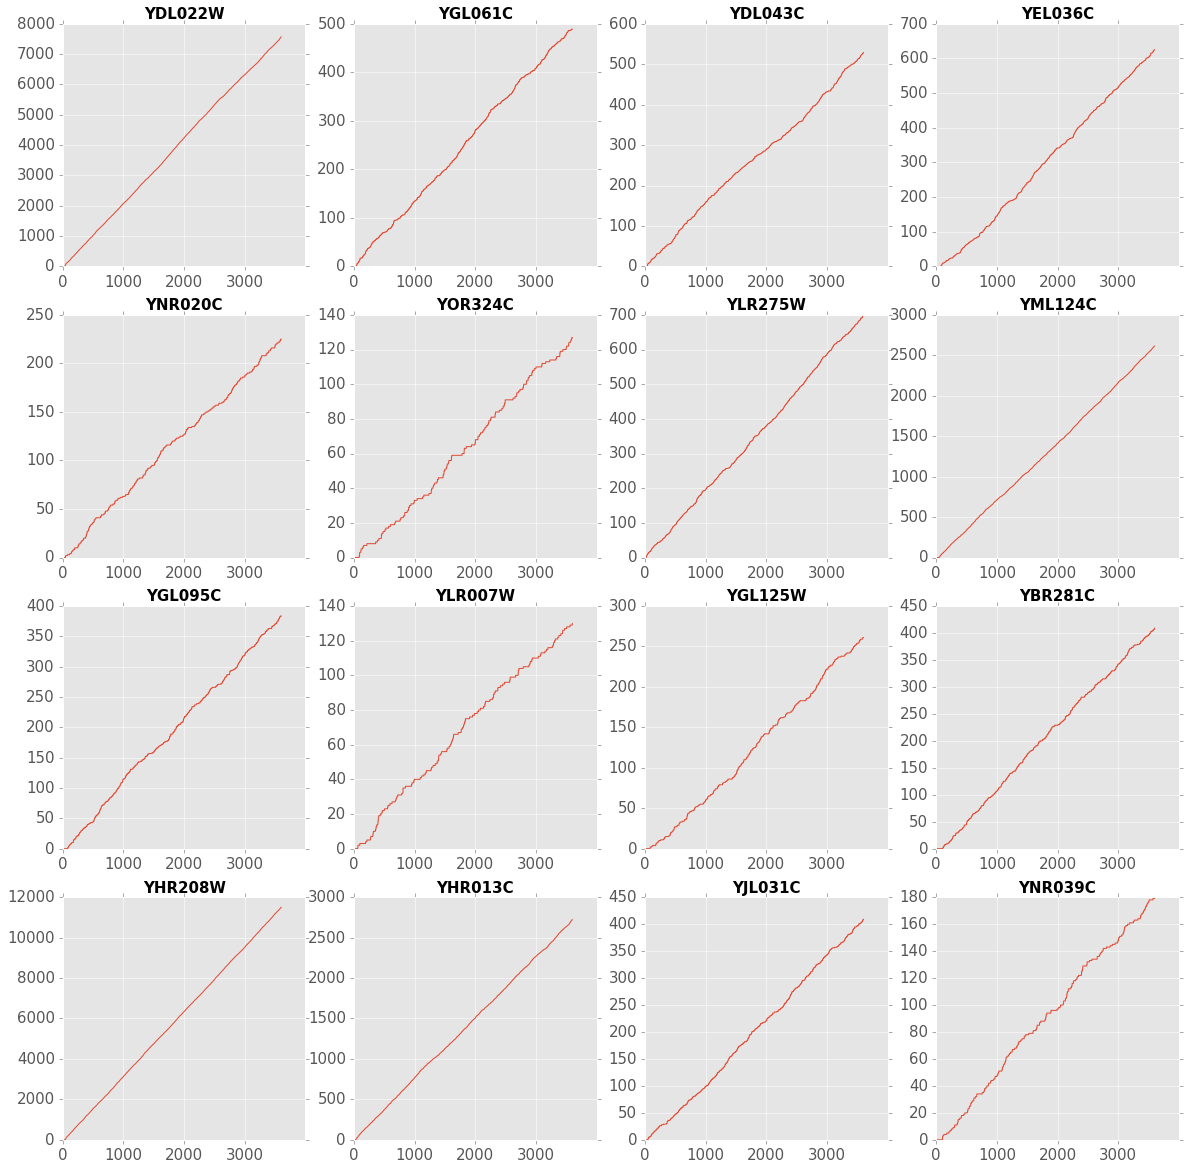

In [27]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))

for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = results['timecourses'][protnames_plot[i][j]]
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 1000.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 15, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)

Do the same by normalizing by transcript abundance:

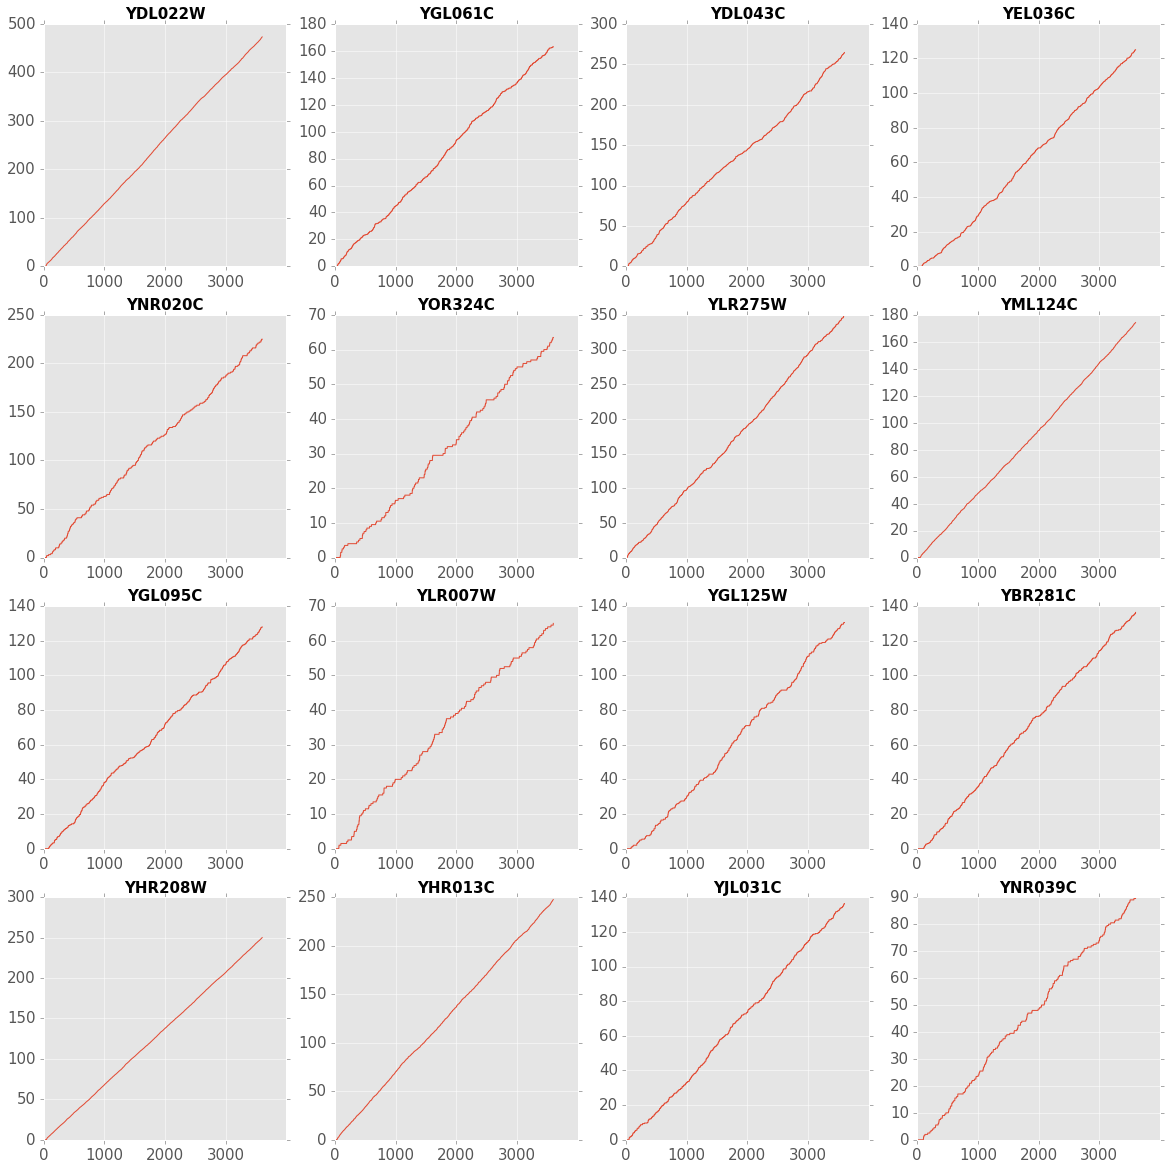

In [28]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = np.array(results['timecourses'][protnames_plot[i][j]])/(1.0*transcriptome_shah[protnames_plot[i][j]])
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 1000.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 15, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)

For each protein, calculate speed of translation:

In [29]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 145.732513363
YAL038W 123.382090925
YJL189W 115.129597701
YCR012W 112.474280131
YOL086C 117.847002701
YLR110C 108.481521927
YLR044C 193.922988506
YKL152C 115.671302948


In [30]:
pd.Series(prot_speeds.values()).describe()

count    4475.000000
mean        1.349305
std         7.847669
min         0.001149
25%         0.049425
50%         0.122989
75%         0.379763
max       193.922989
dtype: float64

In [31]:
pkl.dump(prot_speeds, open("../../parameters/prot_speeds.p", "wb"))

Distribution of translation speeds (finished protein molecules per second, every protein is one datapoint):

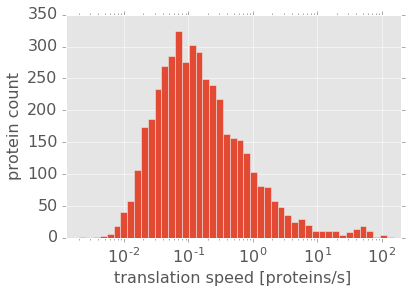

In [32]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]', fontsize=16)
plt.gca().set_ylabel('protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Three orders of magnitude. Let us check how much of this is explained by transcript abundance.

Again try the same for proteins normalized by transcript abundance (proteins/transcript/sec):

In [33]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.20: 
        print prot, prot_per_transcript_speeds[prot]

YJL189W 0.208333333333
YJL158C 0.22127708489
YDR461W 0.23591954023
YLR325C 0.200287356322
YDR224C 0.224150813265
YLR061W 0.200574712644
YLR388W 0.231321839081


In [34]:
pd.Series(prot_per_transcript_speeds).describe()

count    4475.000000
mean        0.046298
std         0.029389
min         0.000575
25%         0.026149
50%         0.039370
75%         0.058621
max         0.235920
dtype: float64

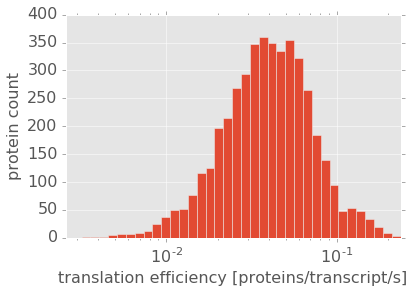

In [35]:
plt.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
plt.gca().set_xlabel('translation efficiency [proteins/transcript/s]', fontsize=16)
plt.gca().set_ylabel('protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Only one order of magnitude distribution left after division by transcript abundance.

Measure the 1%-99% range (Weinberg et al. say it is 21-fold, Ingolia 100-fold):

In [36]:
print pd.Series(prot_per_transcript_speeds).quantile(0.01)
print pd.Series(prot_per_transcript_speeds).quantile(0.99)
print pd.Series(prot_per_transcript_speeds).quantile(0.99)/pd.Series(prot_per_transcript_speeds).quantile(0.01)

0.00775906661303
0.158704523249
20.4540740741


Closer to Weinberg et al. The distribution is also asymmetric in a similar way as in Fig. 5A of Weinberg et al.

In [37]:
pkl.dump(prot_per_transcript_speeds, open("../../parameters/prot_per_transcript_speeds.p", "wb"))

We next compare this with experimental values by Arava et al. (http://www.pnas.org/content/100/7/3889.full):

In [38]:
prot_exp = pkl.load(open("../../parameters/prot_arava.p"))
prot_exp = {gene: prot_exp[gene] for gene in prot_exp if prot_exp[gene] > 1e-16}

prot_per_transcript_exp = pkl.load(open("../../parameters/prot_per_transcript_arava.p"))
prot_per_transcript_exp = {gene: prot_per_transcript_exp[gene] for gene in prot_per_transcript_exp 
                           if prot_per_transcript_exp[gene] > 1e-16}

In [39]:
pd.Series(prot_exp).describe()

count    5643.000000
mean        0.341868
std         1.122374
min         0.000708
25%         0.038661
50%         0.102964
75%         0.257080
max        22.142236
dtype: float64

Function to plot two dictionaries by their values:

In [40]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

4188


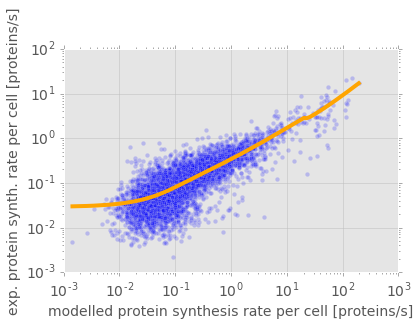

In [41]:
scatter_dicts(prot_speeds, prot_exp, "modelled protein synthesis rate per cell [proteins/s]",
              "exp. protein synth. rate per cell [proteins/s]", 14)

Note: both axes are protein synthesis rates per cell (not per transcript).

Now per transcript:

4188


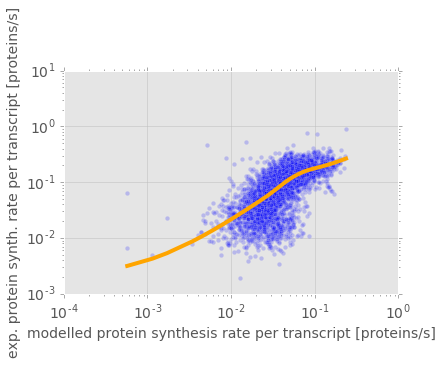

In [42]:
scatter_dicts(prot_per_transcript_speeds, prot_per_transcript_exp,
              "modelled protein synthesis rate per transcript [proteins/s]",
              "exp. protein synth. rate per transcript [proteins/s]", 14)

This one makes more sense as it (probably) reduces the effect of the transcript abundance which was (probably) different between our model and Arava et al.

Reasonable correlation between modelled and experimental values.

Now we test the same with Weinberg/Shah's protein synthesis rates:

In [43]:
prot_per_transcript_exp_weinberg = pkl.load(open("../../parameters/prot_weinberg.p"))
prot_per_transcript_exp_weinberg = {gene: prot_per_transcript_exp_weinberg[gene] 
                                    for gene in prot_per_transcript_exp_weinberg 
                                    if prot_per_transcript_exp_weinberg[gene] > 1e-16}

In [44]:
pd.Series(prot_per_transcript_exp_weinberg).describe()

count    4839.000000
mean        0.047032
std         0.033848
min         0.000028
25%         0.024962
50%         0.038756
75%         0.058887
max         0.432192
dtype: float64

4475


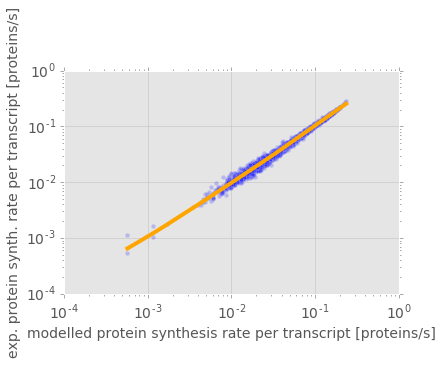

In [45]:
scatter_dicts(prot_per_transcript_speeds, prot_per_transcript_exp_weinberg,
              "modelled protein synthesis rate per transcript [proteins/s]",
              "exp. protein synth. rate per transcript [proteins/s]", 14)

Slight systematic deviation:

In [46]:
np.mean(prot_per_transcript_speeds.values())/np.mean(prot_per_transcript_exp_weinberg.values())

0.98440448957387428

In [47]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [48]:
pd.Series(peptide_speeds.values()).describe()

count      4475.000000
mean        397.912203
std        2650.094505
min           1.278809
25%          22.335776
50%          54.025806
75%         151.598603
max      109372.565517
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second, every protein is one datapoint):

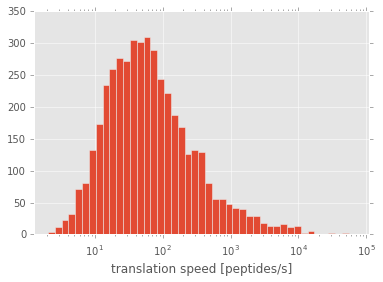

In [49]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [50]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds [bonds/second]']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates [per second]']

#df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
#df3.columns = ['name', 'transcriptome_plotkin']

df4 = pd.DataFrame.from_dict(transcriptome_shah.items())
df4.columns = ['name', 'transcript abundance']
df4 = df4[df4['transcript abundance'] >= 0.1]

In [51]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
#df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df4, left_on='name', right_on='name', how='outer')
df[:20]

,name,peptide_speeds [bonds/second],init_rates [per second],transcript abundance
0,YBR177C,139.626437,1.644214e-06,6.0
1,YIL140W,82.163218,1.649229e-06,2.0
2,YLR268W,92.924881,1.844285e-06,8.0
3,YOR011W,10.022128,2.686820e-07,1.0
4,YPL043W,286.621839,2.096261e-06,7.0
5,YJL155C,19.786207,1.490352e-06,1.0
6,YLL062C,13.168103,1.416694e-06,1.0
7,YLR197W,1617.451149,2.312627e-06,46.0
8,YAL008W,50.381919,3.024409e-06,3.0
9,YOR043W,58.495977,7.775814e-07,5.0


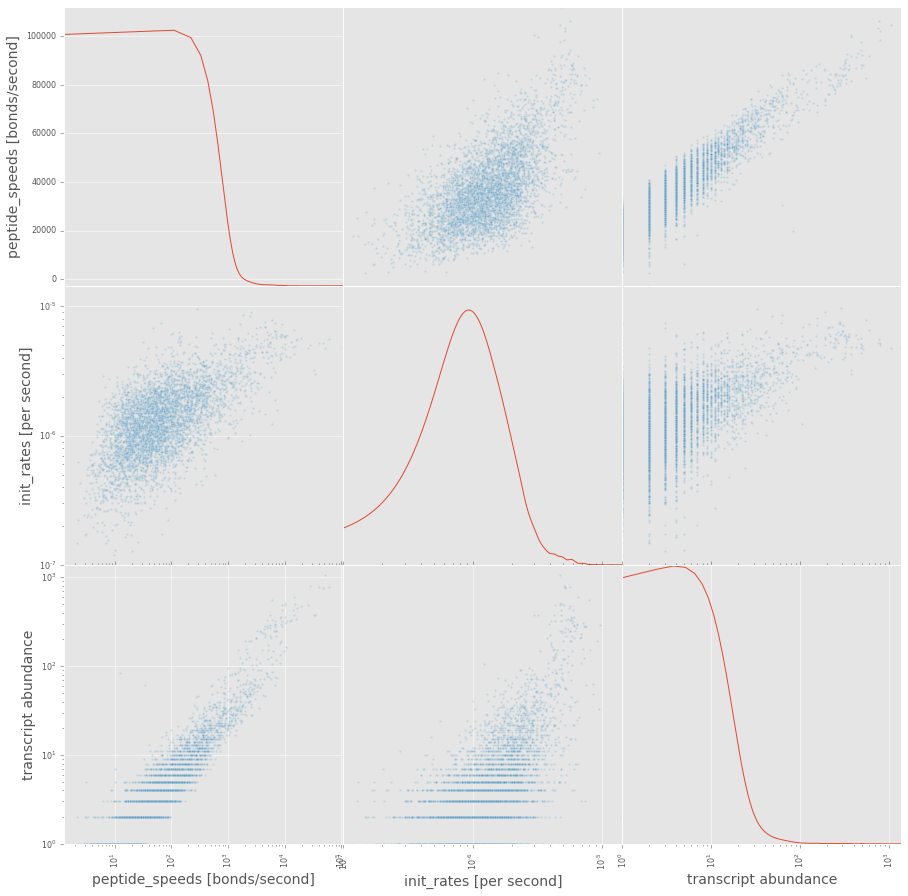

In [52]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

[plt.setp(item.yaxis.get_label(), 'size', 14) for item in axl.ravel()]
[plt.setp(item.xaxis.get_label(), 'size', 14) for item in axl.ravel()]

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0000001, df[df.columns[i+1]].min())
        minj = max(0.0000001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.tick_params(axis='both', which='major', labelsize=14)
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')
            #ax.tick_params(axis='both', which='major', labelsize=14)

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs.

The following is smaller than 20000 (or 60000), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [53]:
len(results['transcriptome'])

57508

In [54]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [55]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [57]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [58]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [59]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [60]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [61]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [62]:
pd.Series(orf_lengths.values()).describe()

count     6713.000000
mean      1352.414122
std       1139.682772
min         51.000000
25%        534.000000
50%       1077.000000
75%       1767.000000
max      14733.000000
dtype: float64

In [63]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [64]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

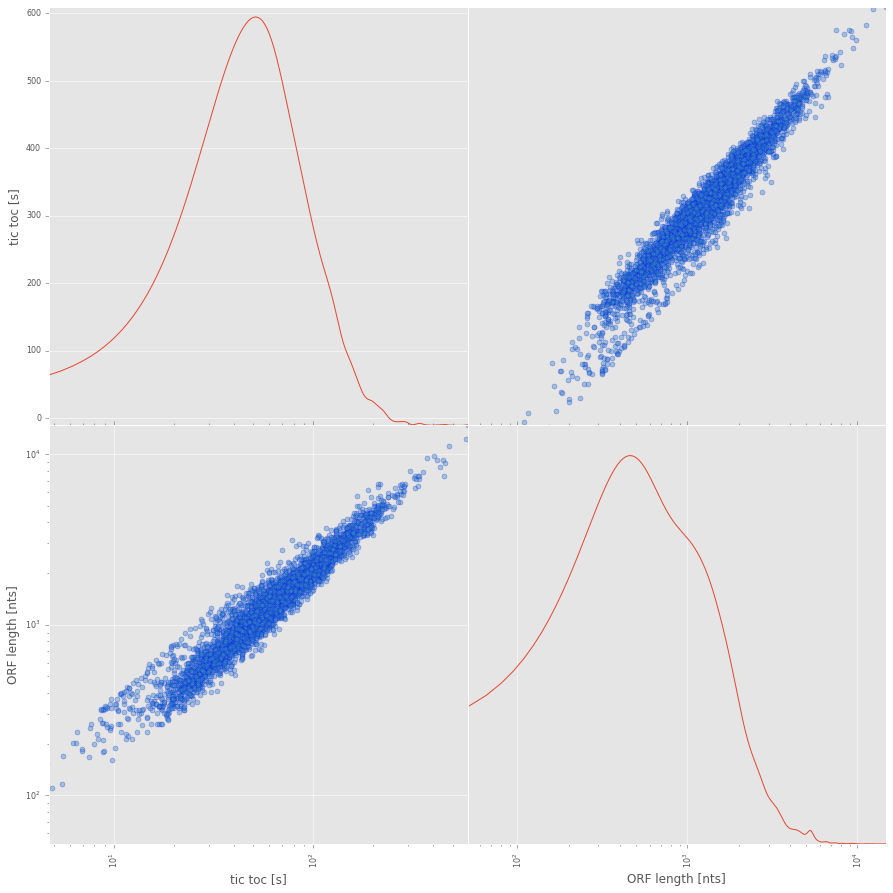

In [73]:
axl = pd.scatter_matrix(df, alpha=0.4, figsize=(15, 15), diagonal='kde', marker='o', s=25, color='b')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')

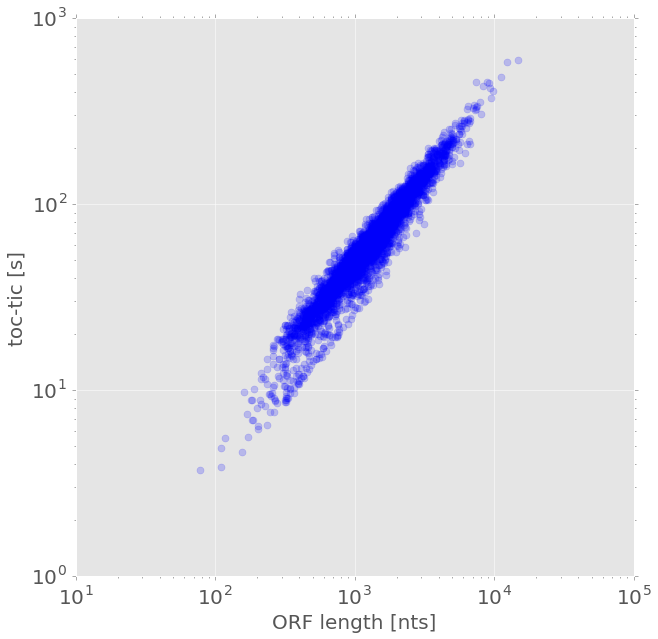

In [79]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.2, s=50, color='b')
ax.set_xlabel('ORF length [nts]', fontsize=20)
ax.set_ylabel('toc-tic [s]', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')

Plot of ORF lengths vs Translation efficiency:

4475


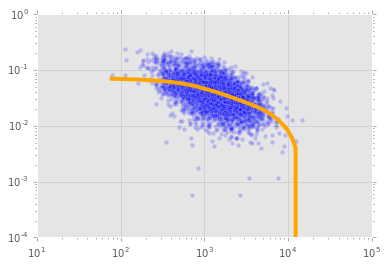

In [80]:
scatter_dicts(orf_lengths, prot_per_transcript_speeds)

Looks like Fig. 6C in Weinberg et al.

To account for the ORF lengths, we normalize by them:

In [81]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [82]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    4475.000000
mean        0.047506
std         0.007730
min         0.024458
25%         0.042902
50%         0.047468
75%         0.052272
max         0.080742
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([  21.,   48.,   40.,   66.,   73.,   90.,  151.,  221.,  306.,
         417.,  513.,  524.,  476.,  440.,  341.,  271.,  158.,  127.,
          67.,   52.,   27.,   20.,    7.,    7.,    5.,    3.,    2.,    1.]),
 array([ 0.02445785,  0.02645785,  0.02845785,  0.03045785,  0.03245785,
         0.03445785,  0.03645785,  0.03845785,  0.04045785,  0.04245785,
         0.04445785,  0.04645785,  0.04845785,  0.05045785,  0.05245785,
         0.05445785,  0.05645785,  0.05845785,  0.06045785,  0.06245785,
         0.06445785,  0.06645785,  0.06845785,  0.07045785,  0.07245785,
         0.07445785,  0.07645785,  0.07845785,  0.08045785]),
 <a list of 28 Patch objects>)

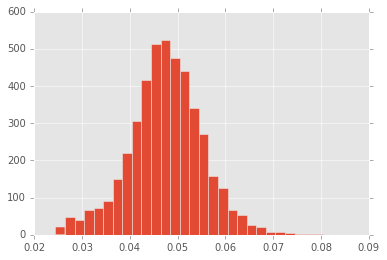

In [86]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.002))

In [87]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

[None, None, None, None, None, None, None, None, None, None]

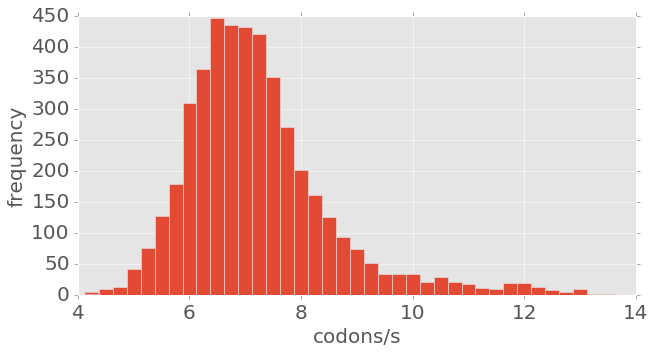

In [89]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.25))
ax.set_xlabel('codons/s', fontsize=20)
ax.set_ylabel('frequency', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)

Broadly in line with bionumbers: 1-10 codons per second

http://bionumbers.hms.harvard.edu/search.aspx?log=y&task=searchbytrmorg&trm=ribosome+rate&time=2015%2f09%2f25+08%3a06%3a19.092

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [91]:
import shelve

#filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"
#filepath = "../../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160906_1753.db"
filepath = "../../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20170331_2025.db"
d = shelve.open(filepath, flag='r')

ImportError: No module named gdbm

Populate a dictionary with ribosome "lattices":

In [71]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

First we plot the ribosome densities per gene:

In [72]:
ribo_density_per_100nt_dict = {key: sum(ribo_lattice_dict[key]) * 100.0 / 3.0 / len(ribo_lattice_dict[key]) / 
                               transcriptome_shah[key] for key in ribo_lattice_dict}

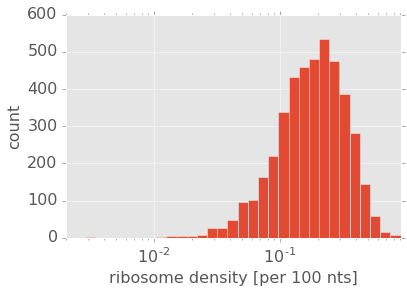

In [73]:
plt.hist(ribo_density_per_100nt_dict.values(), 
         bins = 10**np.linspace(np.log10(min(ribo_density_per_100nt_dict.values())+0.0001), 
                                np.log10(max(ribo_density_per_100nt_dict.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(ribo_density_per_100nt_dict.values())+0.002, max(ribo_density_per_100nt_dict.values())])
plt.gca().set_xlabel('ribosome density [per 100 nts]', fontsize=16)
plt.gca().set_ylabel('count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Arava et al. (2003) report 0.03 to 3.3 ribosomes per 100 nts. This is a bit lower on the right than these numbers, otherwise acceptable. The 100-fold range is replicated by our model.

To make the ribosomes into a data frame, all array have to have the same length:

In [74]:
# length of longest polysome in codons
max_codons = len(max(ribo_lattice_dict.values(), key=len))

# fill up with None values
for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], \
                                        [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [75]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df[:15]

,YAL001C,YAL002W,YAL003W,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,YAL013W,...,YPR184W,YPR185W,YPR186C,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR198W,YPR199C
0,0,0,5,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,5,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check number of ribosomes in this data frame:

In [76]:
sum(dict(ribo_lattice_df.sum()).values())

167416.0

It is more convenient to remove the `None` values from `ribo_lattice_dict`:

In [77]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

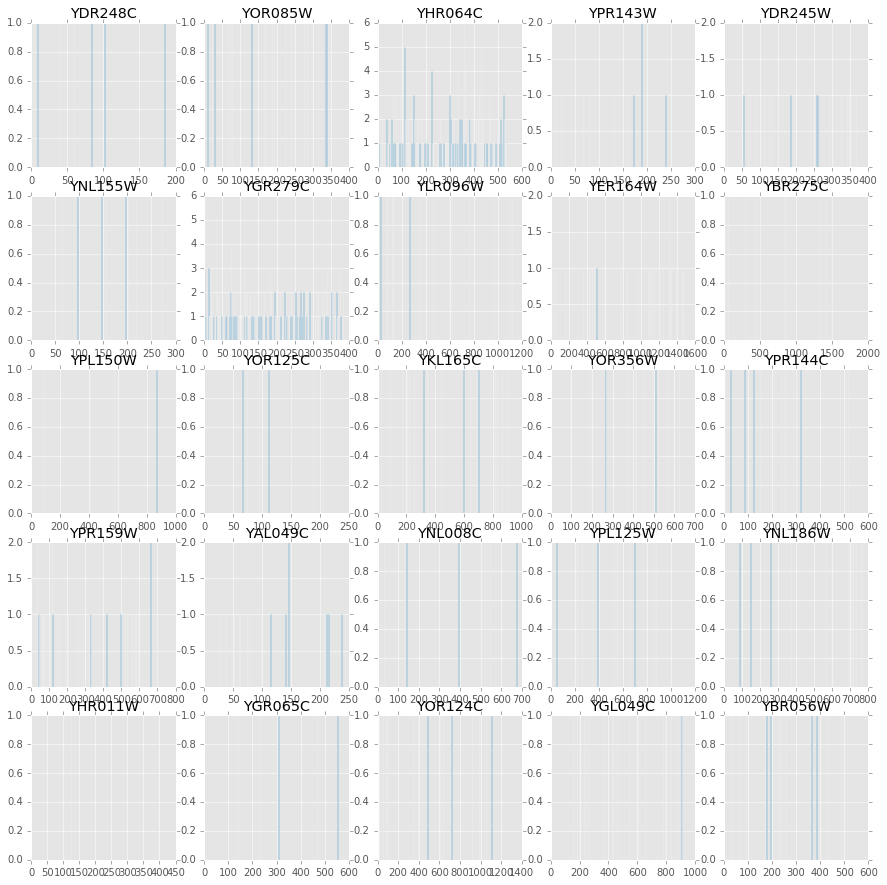

In [78]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(15, 15))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]]]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])

Average ribosome number per gene (average along the mRNA, across all codons):

In [79]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Scatter plot against ORF lengths (mostly to rule out a mistake with the different lengths):

4326


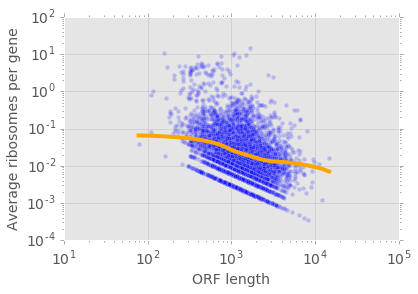

In [80]:
scatter_dicts(orf_lengths, {gene: average_ribos_per_gene[gene] for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene] > 1e-16}, 'ORF length', 'Average ribosomes per gene', 14)

No recognizable correlation - probably correct!

This means dividing by the length takes care of the correlation.

Normalize by transcript abundance:

In [81]:
transcriptome = transcriptome_shah # pkl.load(open("../parameters/transcriptome_plotkin.p", "rb"))

In [82]:
print len(transcriptome)
print sum(transcriptome.values())

4839
60006


In [83]:
average_ribos_per_transcript = {gene: np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

In [84]:
total_ribos_per_transcript = {gene: sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

Plot against ORF length:

4326


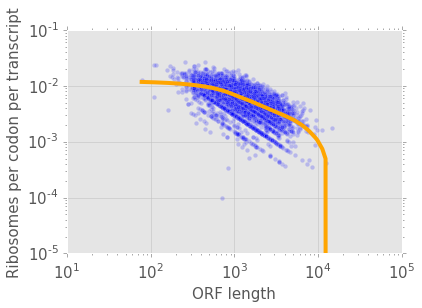

In [85]:
scatter_dicts(orf_lengths, average_ribos_per_transcript, 'ORF length', 'Ribosomes per codon per transcript', 15)

4326


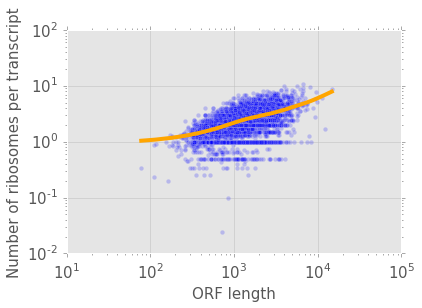

In [86]:
scatter_dicts(orf_lengths, total_ribos_per_transcript, 'ORF length', 'Number of ribosomes per transcript', 15)

This is a relatively weak dependence because shorter genes have higher initiation rates which counteracts the (expected) length effect.

Plot against initiation rate:

4326


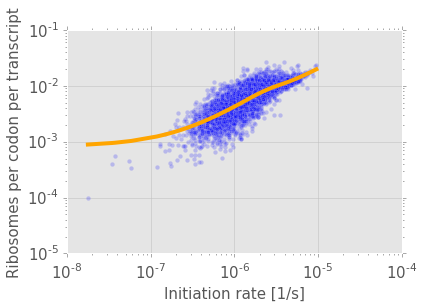

In [87]:
scatter_dicts(init_rates_plotkin, average_ribos_per_transcript, "Initiation rate [1/s]", \
              'Ribosomes per codon per transcript', 15)

In [88]:
1/np.mean(average_ribos_per_transcript.values())

160.12194832985273

2489


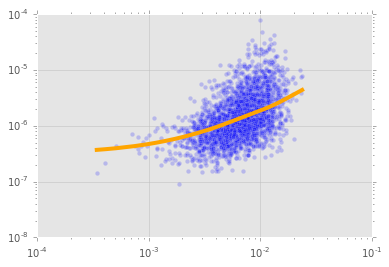

In [89]:
scatter_dicts(average_ribos_per_transcript, init_rates_plotkin_old)

4716


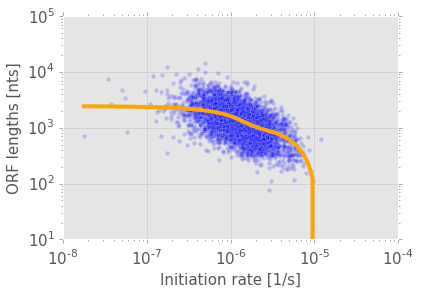

In [90]:
scatter_dicts(init_rates_plotkin, orf_lengths, "Initiation rate [1/s]", \
              "ORF lengths [nts]", 15)

TODO: what explains the remaining dispersion? TODO: check CAI?

### 4. Ribosome ramp

Analysis by codon position:

In [91]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [92]:
ribo_lattice_df_normalized.head()

,YAL001C,YAL002W,YAL003W,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,YAL013W,...,YPR184W,YPR185W,YPR186C,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR198W,YPR199C
0,0,0,0.015528,0,0,0,0,0,0.025641,0,...,0,0,0,0,0.166667,0,0,0,0,0
1,0,0,0.0124224,0,0,0,0,0,0.025641,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0124224,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.0186335,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0217391,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
means_per_position = ribo_lattice_df_normalized.mean(axis=1, numeric_only=None)
means_per_position

0       0.011595
1       0.005060
2       0.006767
3       0.005348
4       0.005639
5       0.006188
6       0.007109
7       0.005744
8       0.005661
9       0.005924
10      0.005015
11      0.006303
12      0.007268
13      0.006172
14      0.005019
15      0.007386
16      0.006666
17      0.005878
18      0.006013
19      0.006142
20      0.006399
21      0.006930
22      0.007505
23      0.004879
24      0.006756
25      0.005602
26      0.006319
27      0.006924
28      0.005676
29      0.005248
          ...   
4881    0.000000
4882    0.000000
4883    0.000000
4884    0.000000
4885    0.000000
4886    0.000000
4887    0.000000
4888    0.000000
4889    0.000000
4890    0.000000
4891    0.000000
4892    0.000000
4893    0.000000
4894    0.000000
4895    0.000000
4896    0.000000
4897    0.000000
4898    0.000000
4899    0.000000
4900    0.000000
4901    0.000000
4902    0.000000
4903    0.000000
4904    0.000000
4905    0.000000
4906    0.000000
4907    0.000000
4908    0.0000

In [94]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
positions

4911

/home/martin/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


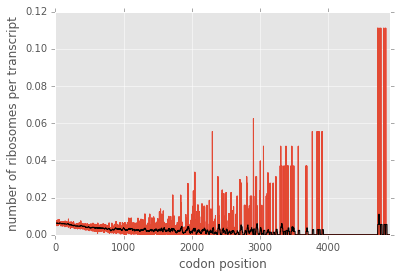

In [95]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
#plt.xlim([0, 500])
#plt.ylim([0, 0.01])
#plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

/home/martin/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


[None, None, None, None, None, None]

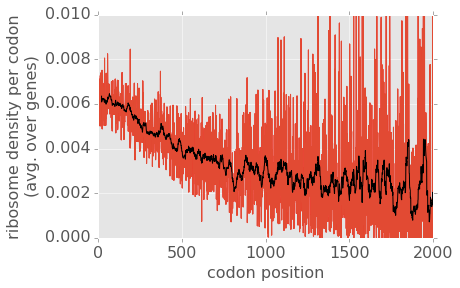

In [96]:
ts = means_per_position

ts.plot(style='r').set_xlabel('codon position', fontsize=16)
ts.plot().set_ylabel('ribosome density per codon\n(avg. over genes)', fontsize=16)
pd.rolling_mean(ts, 20).plot(style='k')

ax = plt.subplot(111)
ax.set_xlim([0.0, 2000.0])
ax.set_ylim([0.0, 0.01])
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

Let us try on single genes:

Find gene with maximum transcription (for best statistics):

In [97]:
maxgene = max(transcriptome.iterkeys(), key=(lambda key: transcriptome[key]))
maxgene, transcriptome[maxgene]

('YLR044C', 1381)

/home/martin/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  from ipykernel import kernelapp as app


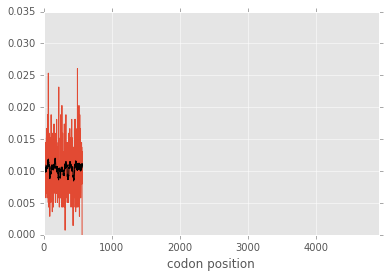

In [98]:
ribo_lattice_df_normalized[maxgene].plot().set_xlabel('codon position')
pd.rolling_mean(ribo_lattice_df_normalized[maxgene], 20).plot(style='k')

No ribosome ramp at individual gene level? This would be consistent with Shah's hypothesis that it is caused by short genes with high initiation probabilities. 

TODO: we need to check this more systematically.

### Ribosome ramp analysis according to Weinberg et al.

Average number of ribosomes per gene (we do not normalize by transcript abundance as normalizing by average number of ribosomes per gene will automatically take care of this):

In [99]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [100]:
pd.Series(avg_ribos_per_gene).describe()

count    4475.000000
mean        0.124712
std         0.624571
min         0.000000
25%         0.006912
50%         0.017104
75%         0.050608
max        14.354610
dtype: float64

Define Weinberg's z (eq. S7):

In [101]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

In [102]:
sum([sum(z[gene]) for gene in z])

2286954.0

z contains many entries > 1 (the zs are normalized to the gene lengths).

Determine genes for the ribosome ramp à la Weinberg:

In [103]:
ramp_genes = set(z.keys()) & set(orf_lengths.keys())
len(ramp_genes)

4326

Longest gene in this set:

In [104]:
max_gene_length = max(orf_lengths.values())/3.0
max_gene_length

4911.0

Excess ribosome densities:

In [105]:
import math

e = []
for j in range(int(max_gene_length)):
    numer = 0.0
    for gene in ramp_genes:
        if orf_lengths[gene]/3 > j:
            if not math.isnan(z[gene][j]):
                numer += z[gene][j]
    denom = sum([1 if orf_lengths[gene] >= j else 0 for gene in ramp_genes]) * 1.0
    e.append(numer/denom)

In [106]:
sum(e)

623.62536717102068

Equation (S10):

In [107]:
eprime = np.array(e) / (sum(e[449:500]) / 51.0)

/home/martin/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()


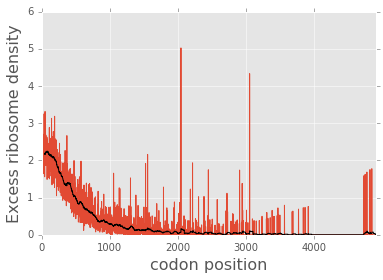

In [108]:
plt.plot(eprime)
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(eprime), 50).plot(style='k')

Clearly visible ribosome ramp!

The excess density of 2.3 (approximately) is closer to that of Ingolia (http://science.sciencemag.org/content/324/5924/218.full, Fig. 2.F) to that of Weinberg et al. (Fig. 1.C)

Curious to see what happens at the peaks (http://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array).

In [109]:
eprime.argsort()[-9:][::-1]

array([2044, 3051,    0,   51,   37,  191,  146,   47,   55])

In [111]:
eprime[2044]

5.0232757116061277

In [112]:
np.array(e).argsort()[-9:][::-1]

array([2044, 3051,    0,   51,   37,  191,  146,   47,   55])

In [114]:
e[2044]

2.3733590413291723

In [115]:
zvals = {gene: z[gene][2044] if len(z[gene])>=2044 else 0 for gene in ramp_genes}
zcomp = {gene: z[gene][2044] if len(z[gene])>=2044 else 0 for gene in ramp_genes}

In [117]:
print max(zvals, key=zvals.get)
print max(zcomp, key=zcomp.get)

YPR117W
YPR117W


"Putative protein of unknown function"

In [118]:
z["YPR117W"][2044]

2490.0

In [119]:
print avg_ribos_per_gene["YPR117W"]
print 1/avg_ribos_per_gene["YPR117W"]

0.000401606425703
2490.0


Partial explanation: this gene has a really low `avg_ribos_per_gene` which is in the denominator.

### SNR and slow codons analysis

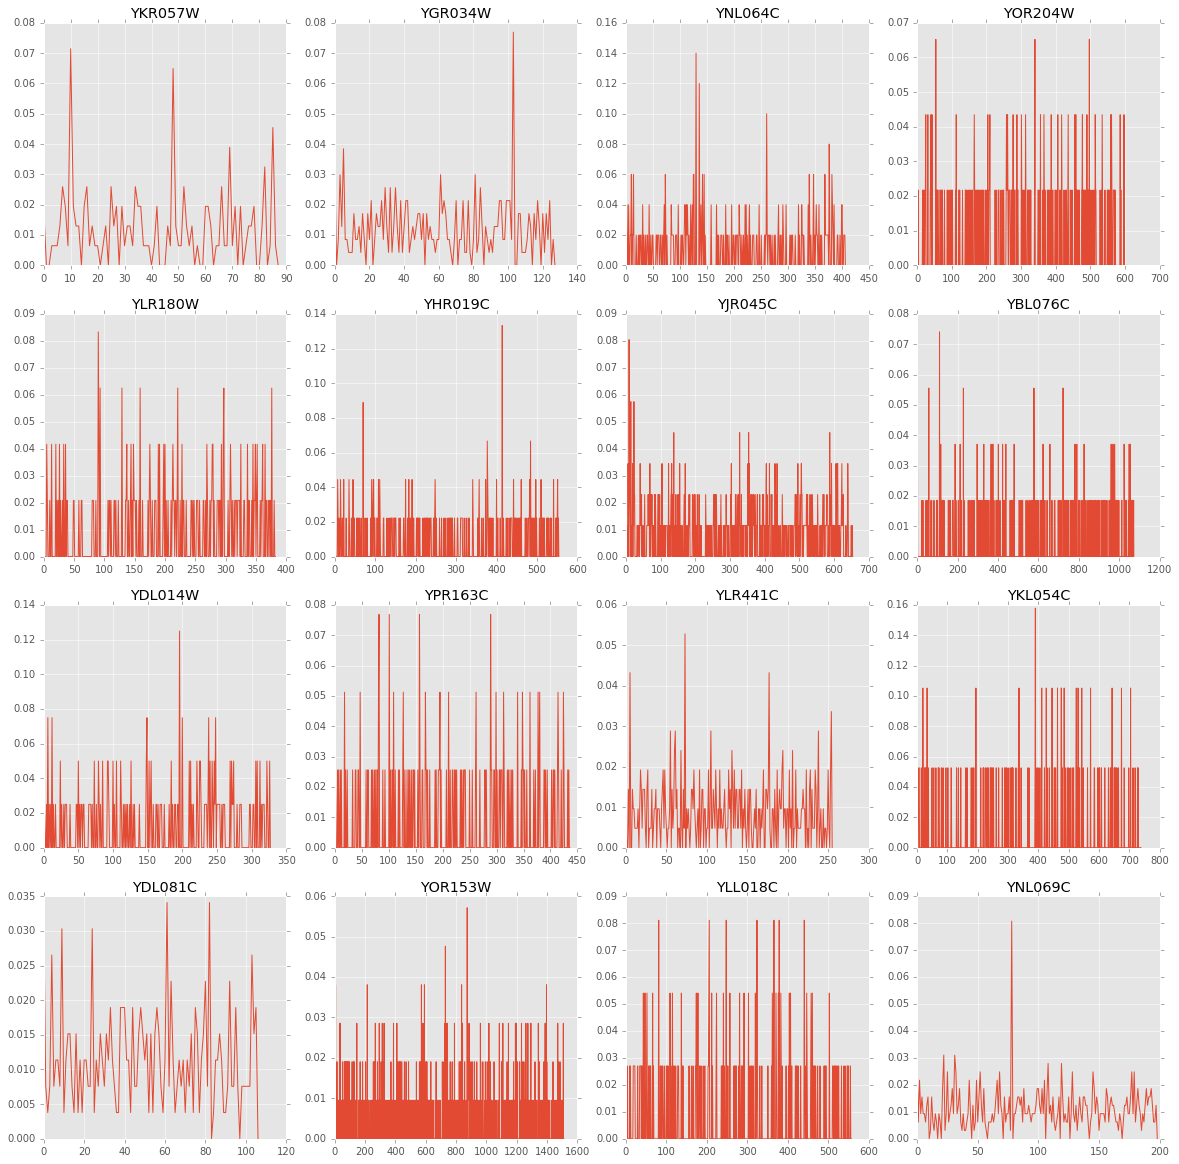

In [120]:
high_transcript_abundance_genes = [gene for gene in ribo_lattice_dict 
                                   if sum([elem for elem in ribo_lattice_dict[gene]]) > 150]

size = 4
genenames_plot = np.array(random.sample(high_transcript_abundance_genes, size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].plot(ribo_lattice_df_normalized[genenames_plot[i][j]])
        #ax[i, j].set_xlabel('codon position')
        ax[i, j].set_title(genenames_plot[i][j])

To calculate the SNR, we establish standard deviations and maxima of the ribosome densities:

In [121]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}
means = {gene: np.mean(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

Find all peaks where the signal to noise ratio is greater than a predefined threoshold:

In [122]:
threshold = 5  # this many standard deviations above the mean are required for a signal to be classified as a peak

peaks = {gene: [(pos, value, (value - means[gene]) / sigmas[gene]) for (pos, value) 
                in enumerate(ribo_lattice_df_normalized[gene]) if (value - means[gene]) / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
         }
        # and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [123]:
peaks['YDL130W'], peaks['YBR078W']

([],
 [(13, 0.09523809523809523, 6.5660234246708447),
  (410, 0.11904761904761904, 8.4204668221148253)])

Find out which codons are typically at peaks (hypothesis is that these might be rare codons):

In [124]:
from translation.TRSL_specific import codon_anticodon, tRNA_types, chunker, complement

In [125]:
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}

In [126]:
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

Define auxiliary function (http://feldboris.alwaysdata.net/blog/python-trick-how-to-flatten-dictionaries-values-composed-of-iterables.html):

In [127]:
from itertools import chain

def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

In [128]:
from collections import Counter

counter = Counter(flatten_dict_values(anticodons_at_peaks))

In [129]:
import collections as col
counter = col.OrderedDict(sorted(counter.items(), key=lambda t: t[1]))
counter

OrderedDict([('ccg', 92),
             ('cca', 156),
             ('acg', 211),
             ('ucu', 232),
             ('cuu', 261),
             ('ccc', 267),
             ('ugg', 295),
             ('caa', 309),
             ('ucc', 325),
             ('aac', 329),
             ('gcc', 341),
             ('agu', 342),
             ('gca', 352),
             ('uug', 360),
             ('ugu', 382),
             ('gug', 386),
             ('agc', 403),
             ('uuc', 416),
             ('cau', 429),
             ('aga', 430),
             ('uaa', 441),
             ('cac', 483),
             ('aau', 502),
             ('ugc', 508),
             ('uac', 515),
             ('gua', 571),
             ('uga', 592),
             ('gaa', 632),
             ('uuu', 639),
             ('cgu', 639),
             ('guc', 641),
             ('uau', 672),
             ('cga', 686),
             ('ccu', 790),
             ('cuc', 863),
             ('uag', 907),
             ('guu', 916),
  

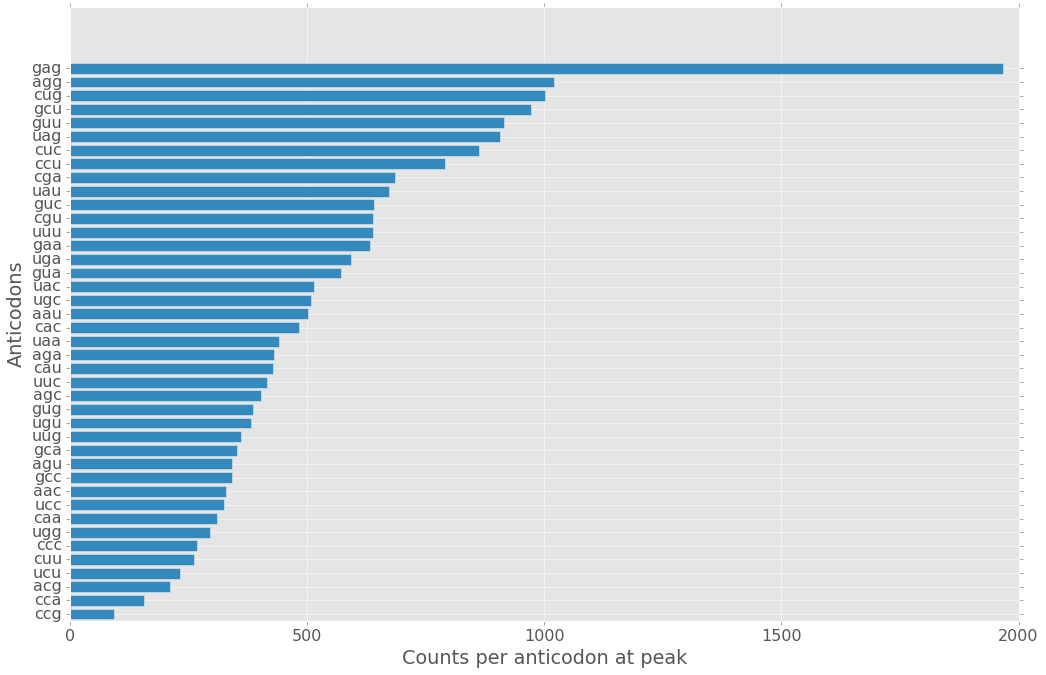

In [130]:
# make a horizontal bar chart

val = counter.values()    # the bar lengths
pos = np.arange(len(counter))+.5    # the bar centers on the y axis

plt.figure(figsize=(17, 11))
matplotlib.rcParams.update({'font.size': 16})
plt.barh(pos, val, align='center')
plt.yticks(pos, counter.keys())
plt.xlabel('Counts per anticodon at peak')
plt.ylabel('Anticodons')
#plt.title('How fast do you want to go today?')
plt.grid(True)

plt.show()

TODO: does this become more pronounced if restricted to high abundance proteins?

In [131]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

41


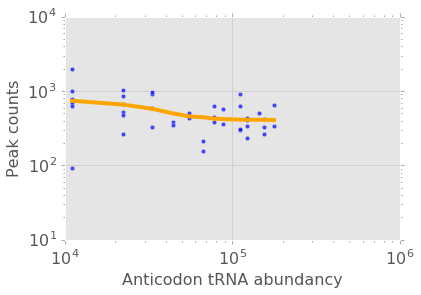

In [132]:
scatter_dicts(anticodon_tRNA_abundancy, counter, "Anticodon tRNA abundancy", "Peak counts", 16, 0.7)

The more tRNAs are available for an anticodon, the fewer peaks happen at these anticodons. Note the log axes.

Anticodon frequency at peaks compared to overall anticodon frequency in _transcriptome_:

The following list contains mRNA sequences times their occurrence in the transcriptome:

In [133]:
transcriptome_weighted_orfs = [orf_genomic_dict[gene] * transcriptome[gene] for gene in transcriptome 
                               if gene in orf_genomic_dict]

These must be converted to anticodons:

In [134]:
anticodon_demand_transcriptome = Counter([codon_anticodon[item] for sublist in [list(chunker(sequence, 3)) 
                                          for sequence in transcriptome_weighted_orfs] 
                                              for item in sublist])
anticodon_demand_transcriptome

Counter({'*': 57508,
         'aac': 1175494,
         'aau': 1187231,
         'acg': 211083,
         'aga': 995101,
         'agc': 1345244,
         'agg': 303015,
         'agu': 950959,
         'caa': 919197,
         'cac': 155937,
         'cau': 441740,
         'cca': 224021,
         'ccc': 77794,
         'ccg': 12669,
         'ccu': 107587,
         'cga': 99555,
         'cgu': 90024,
         'cuc': 279884,
         'cug': 149490,
         'cuu': 1025306,
         'gaa': 911064,
         'gag': 203602,
         'gca': 223945,
         'gcc': 1162068,
         'gcu': 304681,
         'gua': 698588,
         'guc': 1258708,
         'gug': 443567,
         'guu': 1100842,
         'uaa': 467920,
         'uac': 143880,
         'uag': 338330,
         'uau': 175159,
         'ucc': 130441,
         'ucu': 624262,
         'uga': 235840,
         'ugc': 323414,
         'ugg': 632380,
         'ugu': 229125,
         'uuc': 1218385,
         'uug': 641345,
         'uuu':

42


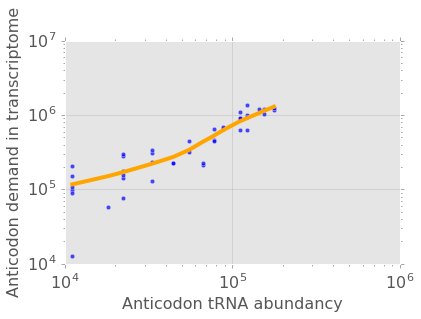

In [135]:
scatter_dicts(anticodon_tRNA_abundancy, anticodon_demand_transcriptome, "Anticodon tRNA abundancy", \
              "Anticodon demand in transcriptome", 16, 0.7)

This is model-free, i.e. only transcriptome vs abundancies.

41


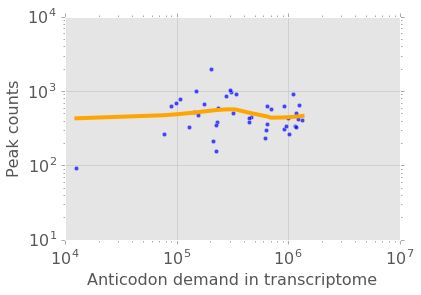

In [136]:
scatter_dicts(anticodon_demand_transcriptome, counter, "Anticodon demand in transcriptome", "Peak counts", 16, 0.7)

### 5. Number of free ribosomes

(0, 70000)

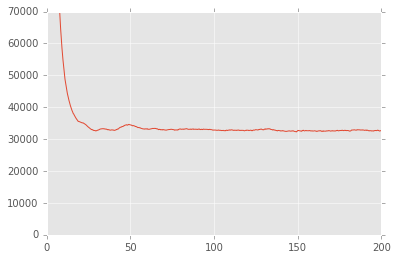

In [138]:
plt.plot(results["timerange"], results["timecourses"]["ribos._free"])
plt.xlim([0, 200])
plt.ylim([0, 70000])

There is a slight oscillation visible at the beginning that washes out towards the end.

In [139]:
results["timecourses"]["ribos._free"][-1] / 200000.

0.16292

16% free ribosomes. (Shah et al. paper has 15%.)

### 6. Scatter plot transcriptome vs. protein synthesis rates

Prediction by Weinberg et al. (2016): the slope of the scatter plot is > 1, indication that translation increases the transcriptional regulation.

4475


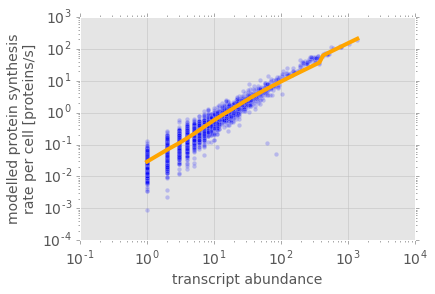

In [140]:
scatter_dicts(transcriptome, prot_speeds, "transcript abundance", "modelled protein synthesis\nrate per cell [proteins/s]",
              14)

Yes the slope is > 1.

### 7. Table of genes by translational efficiency

In [142]:
import csv

with open('../../results/translational_efficiencies.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in prot_per_transcript_speeds.items():
       writer.writerow([key, value])